In [1]:
import numpy as np
from matplotlib import pyplot as plt

from cr_knee_fit.inference import initial_guess_model
from cr_knee_fit.model import ModelConfig
from cr_knee_fit.types_ import Experiment, FitData, Primary

In [2]:
PRIMARIES = [Primary.H, Primary.He]
EXPERIMENTS = [Experiment.AMS02, Experiment.DAMPE]
R_BOUNDS = (7e2, 1e5)  # GV

In [3]:
fit_data = FitData.load(EXPERIMENTS, PRIMARIES, R_BOUNDS)
config = ModelConfig(
    primaries=PRIMARIES,
    shifted_experiments=[e for e in EXPERIMENTS if e is not Experiment.AMS02],
)

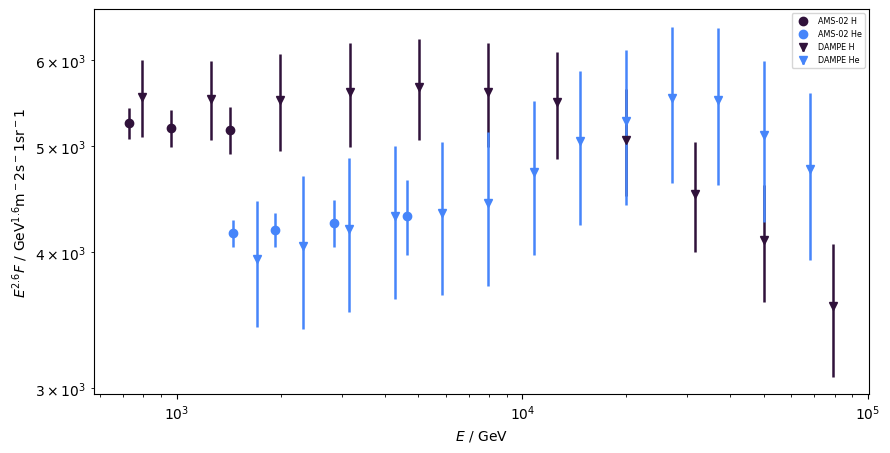

In [4]:
fig, ax = plt.subplots(figsize=(10, 5))

for _, p_data in fit_data.spectra.items():
    for _, data in p_data.items():
        data.plot(scale=2.6, ax=ax)

ax.legend(fontsize="xx-small")
ax.set_xscale("log")
ax.set_yscale("log")

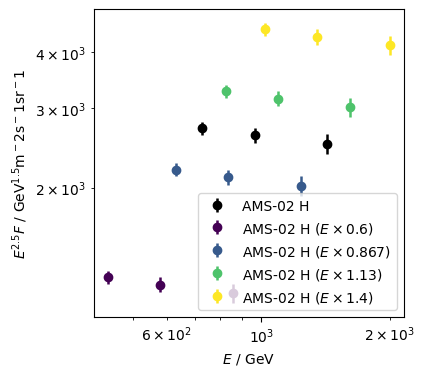

In [5]:
fig, ax = plt.subplots(figsize=(4, 4))
scale = 2.5

cmap = plt.colormaps["viridis"]
fd = fit_data.spectra[EXPERIMENTS[0]][PRIMARIES[0]]
fd.plot(scale, ax=ax, color="black")
for shift in np.linspace(0.6, 1.4, 4):
    fd.with_shifted_energy_scale(f=shift).plot(
        scale, ax=ax, color=cmap((shift - 0.7) / (1.3 - 0.7))
    )
ax.set_xscale("log")
ax.set_yscale("log")

H_lg(I) = -4.16e+00
H_alpha = 2.48e+00
He_lg(I) = -4.93e+00
He_alpha = 2.70e+00
B lg(R_b) = 3.57e+00
B d_alpha = 3.67e-04
B log(s) = 7.25e-01
lg(f_DAMPE) = -1.70e-03


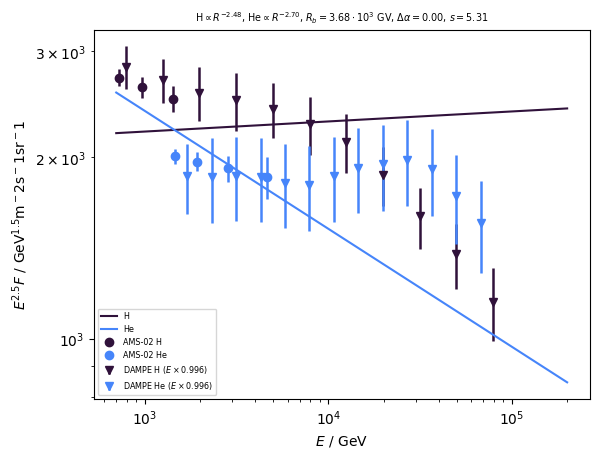

In [6]:
m = initial_guess_model(config)
print(m.format_params())
_ = m.plot(fit_data, scale=2.5)

## Pre-optimization


[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (-0.05, 0.05)]
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1.508842869512027
        x: [-4.080e+00  2.599e+00 -4.961e+00  2.530e+00  4.231e+00
             2.755e-01  2.361e+00 -9.029e-03]
      nit: 74
      jac: [ 1.754e-03  1.039e-04 -8.000e-05  5.025e-04 -1.547e-04
             4.347e-04 -1.554e-07  9.936e-05]
     nfev: 783
     njev: 87
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>


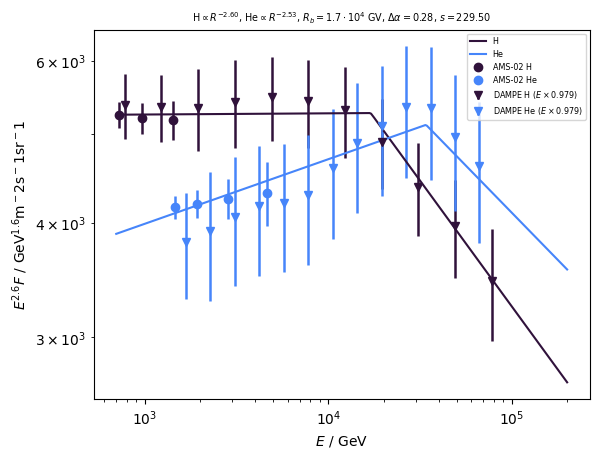

In [7]:
from scipy import optimize

from cr_knee_fit.inference import make_loglikelihood
from cr_knee_fit.model import Model

init_model = initial_guess_model(config)
bounds: list[tuple[float | None, float | None]] = [(None, None)] * init_model.ndim()
# FIXME: unstable dependency on the model packing, assumes energy shifts are packed last
for i in range(len(init_model.energy_shifts.lg_shifts)):
    bounds[len(bounds) - i - 1] = (-0.05, 0.05)
print(bounds)


loglike = make_loglikelihood(fit_data, config)


def minimized_fn(v: np.ndarray) -> float:
    return -loglike(v)


res = optimize.minimize(
    minimized_fn,
    x0=init_model.pack(),
    # method="Nelder-Mead",
    options={
        "maxiter": 100_000,
    },
    bounds=bounds,
)
print(res)

_ = Model.unpack(res.x, layout_info=config).plot(fit_data, scale=2.6)

In [8]:
from cr_knee_fit.inference import make_logposterior, logprior

lp = make_logposterior(fit_data, config)

lp(init_model.pack())

-66277.44921950453

In [9]:
import emcee


n_steps = 10_000
n_walkers = 128
n_dim = init_model.ndim()

sampler = emcee.EnsembleSampler(
    nwalkers=n_walkers,
    ndim=n_dim,
    log_prob_fn=make_logposterior(fit_data, config),
)
initial_state = np.array([initial_guess_model(config).pack() for _ in range(n_walkers)])
sampler.run_mcmc(initial_state, nsteps=n_steps, progress=True)
print(f"Acceptance fraction: {sampler.acceptance_fraction.mean()}")

tau = sampler.get_autocorr_time(quiet=True)
print(f"{tau = }")

burn_in = 5 * int(tau.max())
thin = 2 * int(tau.max())

print(f"{burn_in = } {thin = }")

theta_sample: np.ndarray = sampler.get_chain(flat=True, discard=burn_in, thin=thin)  # type: ignore
print(f"MCMC sample ready, shape: {theta_sample.shape}")

  0%|          | 0/10000 [00:00<?, ?it/s]/home/njvh/Documents/Science/cr-knee-fit/.devenv/state/venv/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [02:25<00:00, 68.53it/s]


Acceptance fraction: 0.32792656249999996


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [ 92.5824516  164.33387402  94.92321769 145.67423433 390.08422083
 390.6895711  143.38878122 136.24171453]


tau = array([ 92.5824516 , 164.33387402,  94.92321769, 145.67423433,
       390.08422083, 390.6895711 , 143.38878122, 136.24171453])
burn_in = 1950 thin = 780
MCMC sample ready, shape: (1280, 8)


In [10]:
theta_sample.shape


(1280, 8)

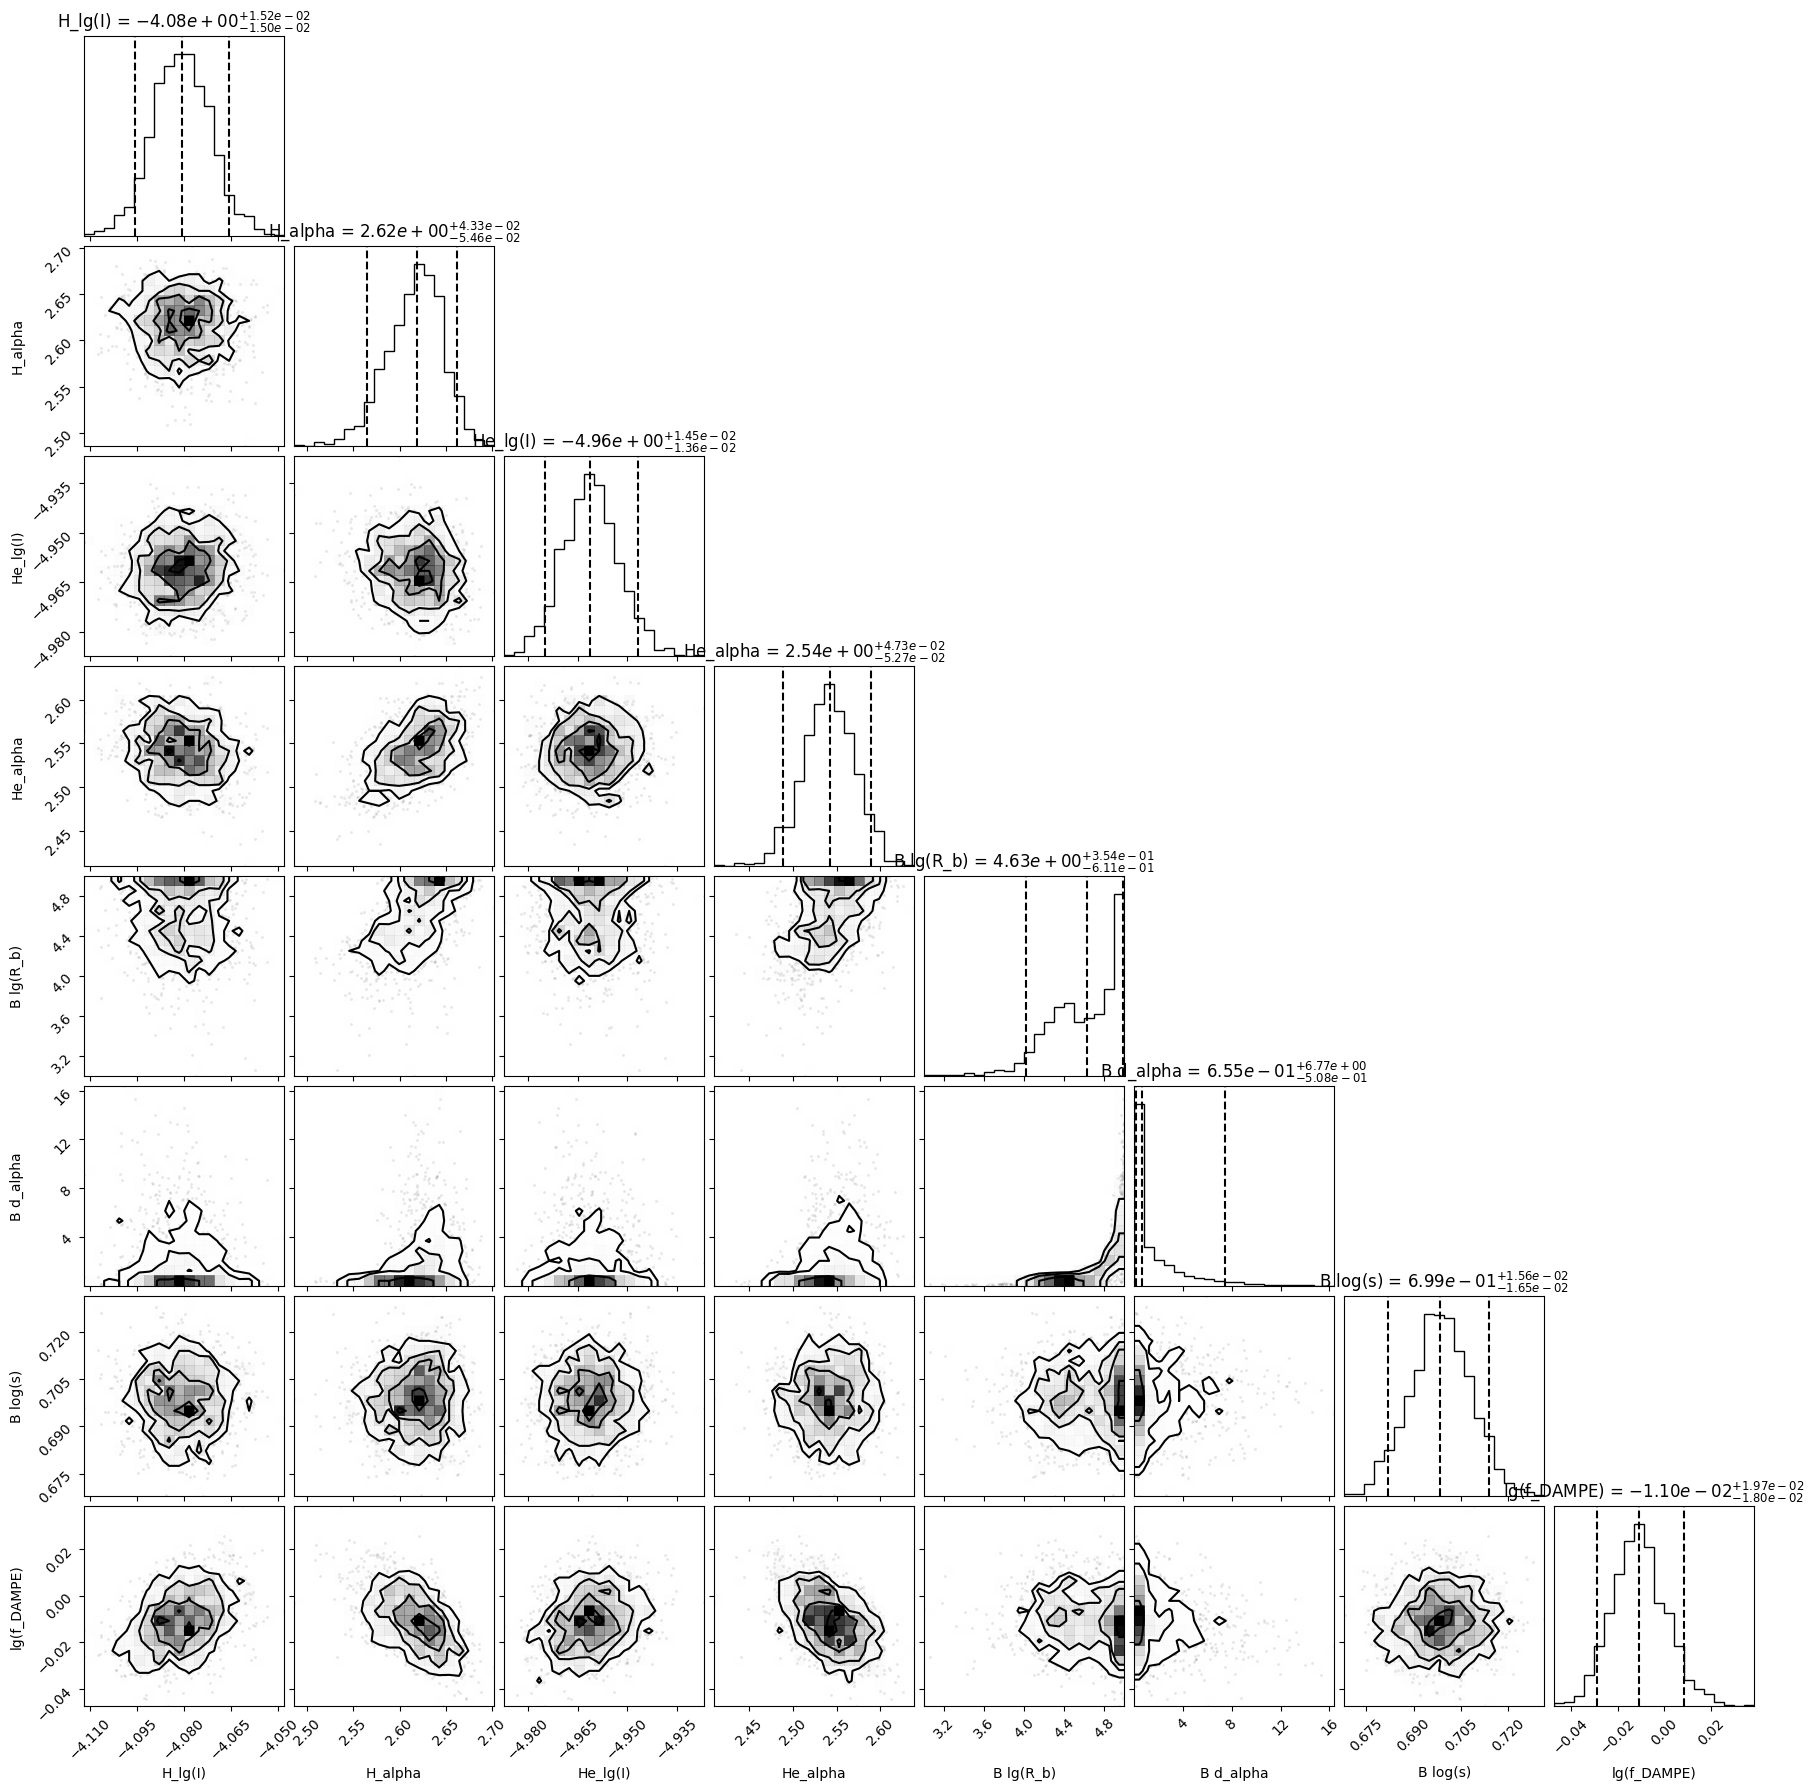

In [11]:
import corner

sample_to_plot = theta_sample
sample_labels = init_model.labels()

_ = corner.corner(
    sample_to_plot,
    labels=sample_labels,
    show_titles=True,
    title_fmt=".2e",
    quantiles=[0.05, 0.5, 0.95],
)

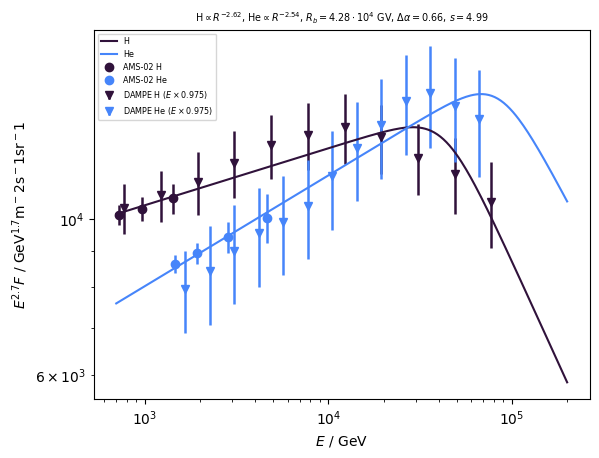

In [15]:
_ = Model.unpack(np.median(theta_sample, axis=0), layout_info=config).plot(fit_data, scale=2.7)